In [ ]:
from pathlib import Path
from pystripe import batch_filter
batch_filter(
    Path(r"/data/20220725_17_41_55_SW220510_02_LS_15x_1000z_stitched/Ex_488_Em_525_tif_deconvolved"),
    Path(r"/data/20220725_17_41_55_SW220510_02_LS_15x_1000z_stitched/Ex_488_Em_525_tif_deconvolved_flip_up"),
    compression = ('ZLIB', 0),
    #convert_to_8bit=True,
    #bit_shift_to_right=4,
    flip_y=True,
    dtype="uint8",
    #tile_size=(8474, 8667),
    #down_sample=(2, 2),
    #new_size=(iiininnt(8474 * 0.422 / 0.5, 8667 * 0.422 / 0.5)
)

In [ ]:
!wine64 imaris/ImarisConvertiv.exe --input /data/20220725_17_41_55_SW220510_02_LS_15x_1000z_stitched/Ex_488_Em_525_tif_merge/img_000000.tif --output /data/20220725_17_41_55_SW220510_02_LS_15x_1000z_stitched/Ex_488_Em_525_tif_merge.ims --inputformat TiffSeries --nthreads 128 --compression 1 --voxelsize 1.0-1.0-1.0 --logprogress

In [ ]:
!mpiexec -np 11 python -m mpi4py ./TeraStitcher/pyscripts/paraconverter.py --sfmt="TIFF (series, 2D)" --dfmt="TIFF (tiled, 3D)" --resolutions="012345" --halve=mean -s="/data/20220725_17_41_55_SW220510_02_LS_15x_1000z_stitched/Ex_488_Em_525_tif/deconvolved" -d="/qnap/3D_stitched_LS/20220725_SW220510_02_LS_6x_1000z/Ex_488_Em_525_TeraFly"

In [ ]:
from pathlib import Path
from process_images import merge_all_channels
merge_all_channels(
    [
        Path(r"/data/20220725_17_41_55_SW220510_02_LS_15x_1000z_stitched/Ex_488_Em_525_tif"),
        Path(r"/data/20220725_17_41_55_SW220510_02_LS_15x_1000z_stitched/Ex_488_Em_525_tif_parastitcher"),
        # Path(r"/data/20220725_17_41_55_SW220510_02_LS_15x_1000z_stitched/Ex_642_Em_680_tif")
    ],
    Path(r"/data/20220725_17_41_55_SW220510_02_LS_15x_1000z_stitched/Ex_488_Em_525_tif_merge"),
    order_of_colors="gbr",
    compression=("ZLIB", 0)
)

### generate average flat

In [ ]:
from pathlib import Path
from parallel_image_processor import parallel_image_processor
from skimage.restoration import denoise_bilateral
def denoise_bilateral_helper(img, sigma_spatial=1, mode="edge"):
    return denoise_bilateral(
        img, sigma_spatial=sigma_spatial, mode=mode).astype(img.dtype)
img_flat_list = parallel_image_processor(
    denoise_bilateral_helper,
    source=Path(r"/data/20220725_17_41_55_SW220510_02_LS_15x_1000z_lightsheet_cleaned_tif_bitshift.g0.r0.b0_stitched/Ex_488_Em_525_tif"),
    destination=None,
    args=(),
    kwargs={"sigma_spatial": 1, "mode": "edge"},
    max_processors=128,
    progress_bar_name="flat"
)

2022-08-29 17:59:47.354771: using 128 workers. 8464 images need be processed.


flat:   1%|###6                                                                                                                                                                                                                                                | 126/8464 [20:03<8:02:01,  3.47s/images]

#### convert avera flats to trimmed mean flat and plot

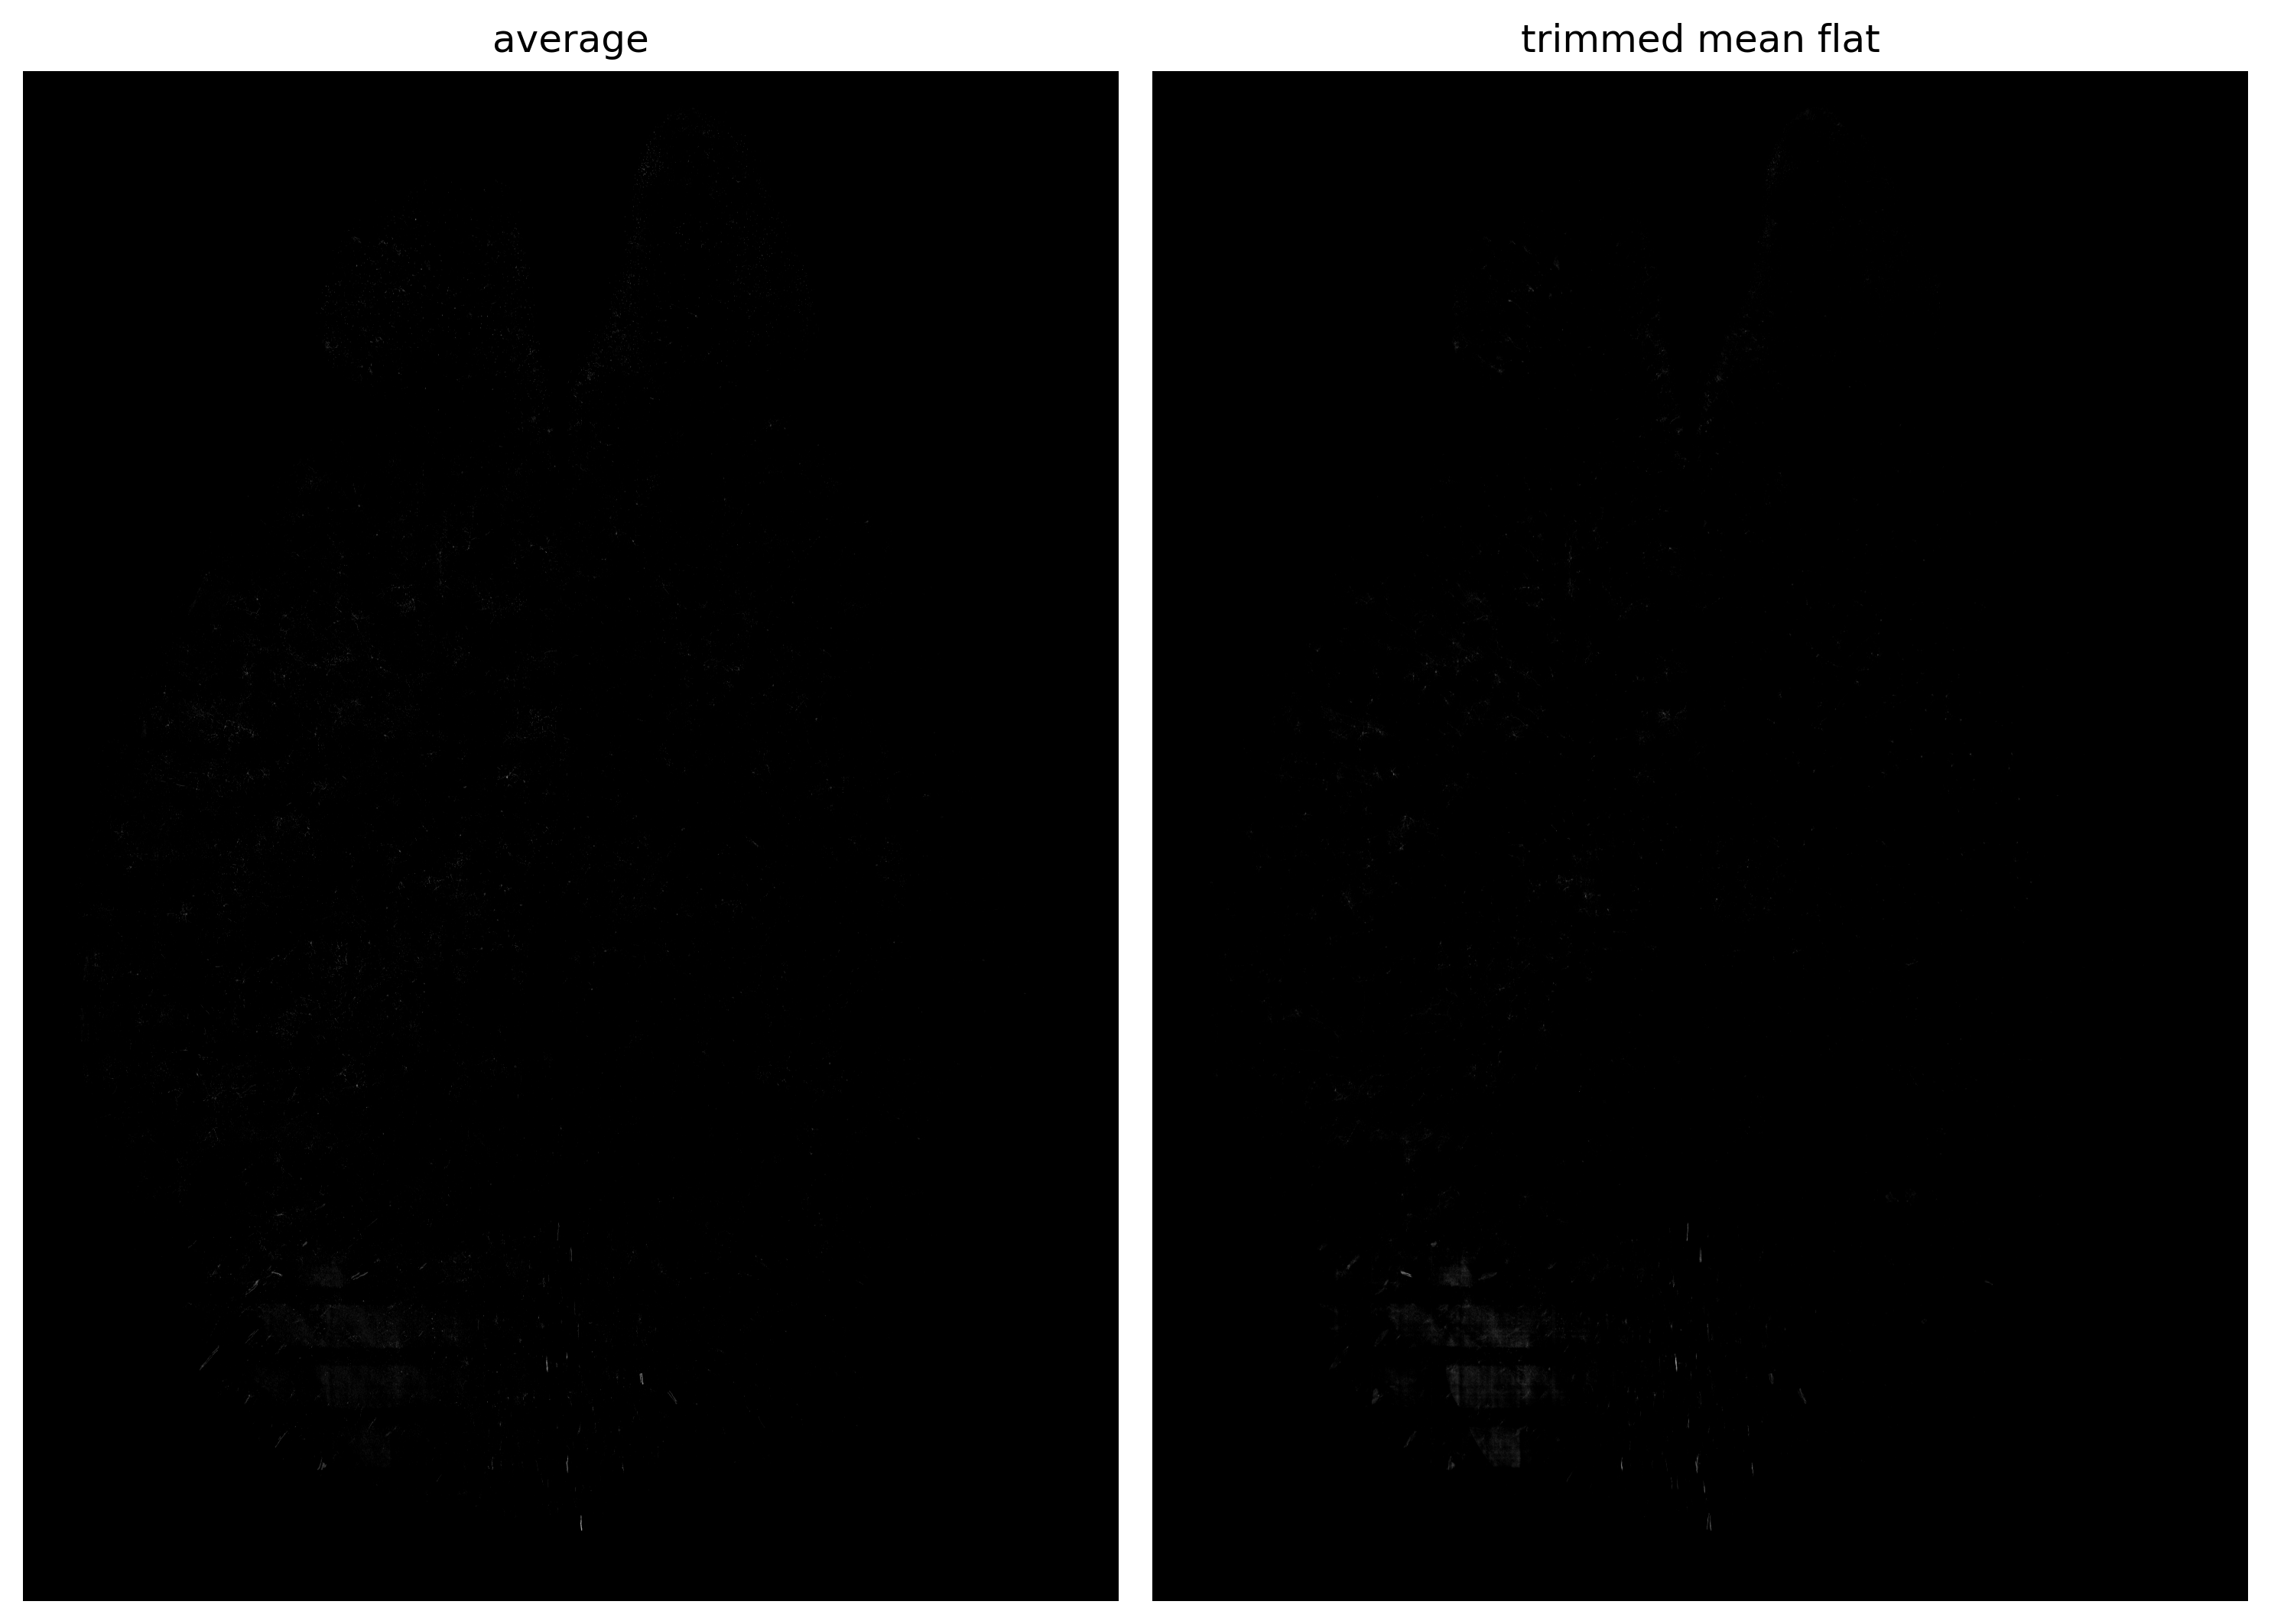

In [7]:
from scipy.stats import trim_mean
import matplotlib.pyplot as plt
from skimage.restoration import denoise_bilateral
img_flat_mean = trim_mean(img_flat_list, 0.1, axis=0)
img_flat_mean = denoise_bilateral(img_flat_mean, sigma_spatial=1, mode="edge")
img_flat_mean = img_flat_mean / img_flat_mean.max()
rc = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "xtick.bottom": False,
    "xtick.labelbottom" : False,
    "ytick.labelleft": False,
    "ytick.left": False,
    "figure.figsize": [20, 10],
    "figure.dpi": 200 
}
fig, axes = plt.subplots(ncols=2, figsize=(10, 10), dpi=300)
axes[0].imshow(img_flat_list[0]/img_flat_list[0].max(), cmap='gray')
axes[0].set_title("average")
axes[1].imshow(img_flat_mean, cmap='gray')
axes[1].set_title("trimmed mean flat")
plt.tight_layout()
plt.show()

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
rc = {
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "axes.spines.top": False,
    "xtick.bottom": False,
    "xtick.labelbottom" : False,
    "ytick.labelleft": False,
    "ytick.left": False,
    "figure.figsize": [20, 10],
    "figure.dpi": 200 
}
plt.rcParams.update(rc)
from pystripe.core import read_filter_save, imread_tif_raw
from skimage.filters import threshold_otsu, gaussian
input_file = Path(r"/data/test/img_000007_croped.tif")
output_file = Path(r"/data/test/img_000007_croped_filtered.tif")
#flat = imread_tif_raw(Path(r"G:\Test_Target\Ex_642_Em_680_flat.tif"))
#flat = gaussian(flat, sigma=1, preserve_range=True, truncate=2).astype(flat.dtype)
read_filter_save(
    input_file, output_file,
    flat=None,
    gaussian_filter_2d=True,
    sigma=(16, 32), level=0, wavelet="db9", crossover=185, threshold=-1, directions='vh',
    dark=0,
    lightsheet=False,
    convert_to_8bit=True,
    bit_shift_to_right=0,
    compression=("ZLIB", 0)
)
img = imread_tif_raw(input_file)
img_f = imread_tif_raw(output_file)
# print(threshold_otsu(img))
fig, axes = plt.subplots(ncols=2, figsize=(10, 10), dpi=300)
axes[0].imshow(img, cmap='gray')
axes[0].set_title("original")
axes[1].imshow(img_f, cmap='gray')
axes[1].set_title("flat")
plt.tight_layout()
plt.show()